**Neural Computing Individual Assignment 2**

---
Low Guo Xuan WID180023 (17143736/1)


Submission deadline is 3rd June (Thursday), 12PM

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import pandas as pd
import collections
import os
from google.colab import files

seed =7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#get correct directory
os.chdir('/content/drive/MyDrive/SEM 6/Neural/Assignment2')

Download data (bymerge)

In [ ]:
transformCustom = transforms.Compose([
                                      transforms.ToTensor(), #convert to tensor
                                      transforms.Lambda(lambda x:x.view(-1)) #flatten 28*28 into 784 vector for each image
                                      ])

train = datasets.EMNIST(root='.',train=True,transform=transformCustom, download=True,split='bymerge')
test = datasets.EMNIST(root='.',train=False,transform=transformCustom, download=True,split='bymerge')

# **Task 1**

Create and implement MLP of your design to classify the EMNIST dataset

Ovierview of data

In [ ]:
# for i in range(1):
#   plt.imshow(train.train_data[i],cmap=plt.get_cmap('gray'))
#   plt.show()

print(train)
print(train.train_data.shape)
print(train.train_labels.shape)

Dataset EMNIST
    Number of datapoints: 697932
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
torch.Size([697932, 28, 28])
torch.Size([697932])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
# According to https://www.simonwenkel.com/2019/07/16/exploring-EMNIST.html#emnist-by- , it have 0-46 classes and the first 10 is digits
tests = pd.Series(train.train_labels).value_counts().sort_index()
# print(tests) # total of 0-46 classes

# According to https://arxiv.org/pdf/1702.05373v1.pdf , the letter classes is in the order of '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
label_list = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt')

print("--Number and Percentages of instances for each classes--")
total = int(train.train_labels.shape[0])
for i,letter in enumerate(label_list):
  print(f'Letter {letter} :   {tests[i]} \t({(int(tests[i])/total)*100:.2f}%)')

--Number and Percentages of instances for each classes--
Letter 0 :   34618 	(4.96%)
Letter 1 :   38304 	(5.49%)
Letter 2 :   34307 	(4.92%)
Letter 3 :   35285 	(5.06%)
Letter 4 :   33656 	(4.82%)
Letter 5 :   31280 	(4.48%)
Letter 6 :   34150 	(4.89%)
Letter 7 :   36020 	(5.16%)
Letter 8 :   33924 	(4.86%)
Letter 9 :   33882 	(4.85%)
Letter A :   6411 	(0.92%)
Letter B :   3874 	(0.56%)
Letter C :   12963 	(1.86%)
Letter D :   4606 	(0.66%)
Letter E :   4925 	(0.71%)
Letter F :   9098 	(1.30%)
Letter G :   2534 	(0.36%)
Letter H :   3097 	(0.44%)
Letter I :   14733 	(2.11%)
Letter J :   5689 	(0.82%)
Letter K :   4998 	(0.72%)
Letter L :   20381 	(2.92%)
Letter M :   11612 	(1.66%)
Letter N :   8237 	(1.18%)
Letter O :   27664 	(3.96%)
Letter P :   10748 	(1.54%)
Letter Q :   2603 	(0.37%)
Letter R :   5047 	(0.72%)
Letter S :   23509 	(3.37%)
Letter T :   9766 	(1.40%)
Letter U :   15388 	(2.20%)
Letter V :   7588 	(1.09%)
Letter W :   7403 	(1.06%)
Letter X :   5598 	(0.80%)
Letter 

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## **T1Q1** 


---


Is the dataset balanced? For both training and test dataset, print out the number of instances for each label (Sample output shown below. This is straightforward as we've done this before) and their percentage with meaningful labels. Which class/label is over/under represented?



> **In my opinion, I think that the dataset is inbalanced. It is because the of difference in the number of instances per labels. The number and percentages of instances for each classes are shown above.**

> **The inbalance of dataset is caused by over represented of the digit classes (0,1,2,3,4,5,6,7,8,9), with all > 4% , under representated of some letter class (G,Q,f,q), with all < 0.5% and missing some letter classes (c,i,j,k,l,m,o,p,s,u,v,w,x,y,z)**


Split data to batches

In [ ]:
batchSize = 128 # Rule of tumb is to set to the power of 2. In this case 2^7
train_loader = DataLoader(train, batch_size = batchSize, shuffle=True)
test_loader = DataLoader(test, batch_size = batchSize, shuffle=False) # no need to shuffle

torch.Size([128, 784]) torch.Size([128])


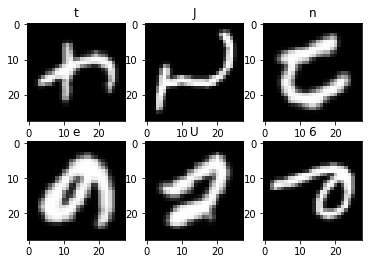

In [ ]:
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.title(label_list[labels[i].detach().numpy()])
  plt.imshow(samples[i].reshape((28,28)), cmap='gray')

In [ ]:
count_batch = 0
for x,y in train_loader:
  count_batch+=1
  # print(f'batch: {count} batch size:{x.shape}')

print(f'There are {count_batch} batches in train dataset')

There are 5453 batches in train dataset


In [ ]:
count_test = 0
for x,y in test_loader:
  count_test+=1
  # print(f'batch: {count} batch size:{x.shape}')

print(f'There are {count_test} batches in test dataset')

There are 909 batches in test dataset


Train data

In [ ]:
class MLP(nn.Module):
  def __init__(self,input_size, hidden_size, num_classes):
    super(MLP,self).__init__()

    self.layer1 = nn.Linear(input_size,hidden_size)
    self.layer2 = nn.Linear(hidden_size,num_classes)

  def forward(self,x):

    out = self.layer1(x)
    out = F.sigmoid(out)
    out = self.layer2(out)

    if not self.training:
      out = F.softmax(out,dim=1) # softmax function convert raw value to probabilities (add up to become 1)
    return out

**Only run when wan to train new model**

In [ ]:
# if wan train new model the run here

model = MLP(784,784,47)

loss_fn = nn.CrossEntropyLoss() #calculate loss by surprise compare to the result
opt = torch.optim.Adam(model.parameters()) #optimizer, optimization strategy to escape the local minima and to converge quickly

epochSize = 10
loss_epoch = []
loss_minibatch = []

for epoch in range(epochSize):
  model.train()
  loss = 0

  for input, target_batch in train_loader:

    opt.zero_grad() #zero the gradients
    predict_batch = model(input) #forward
    loss_batch = loss_fn(predict_batch, target_batch) #loss
    loss_batch.backward() #backward

    opt.step() #optimize i.e update weights

    loss_minibatch.append(loss_batch.item())
    loss += loss_batch.item()

  print(f'Epoch: {epoch+1}  loss: {loss}')
  loss_epoch.append(loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1  loss: 3461.886313036084
Epoch: 2  loss: 2049.5715086609125
Epoch: 3  loss: 1811.9559798538685
Epoch: 4  loss: 1689.1492158323526
Epoch: 5  loss: 1602.6471100896597
Epoch: 6  loss: 1535.1620731726289
Epoch: 7  loss: 1477.625880278647
Epoch: 8  loss: 1429.9689859971404
Epoch: 9  loss: 1385.5977783873677
Epoch: 10  loss: 1347.7224221006036


In [ ]:
# save weights after trained
torch.save(model.state_dict(), "./model.weights")

# needed when want to download to local
# files.download('model.weights')

**Use previous model**

In [ ]:
# needed if download to local
# uploaded = files.upload() #select the saved model.weights

# build the model and load state from drive
model = MLP(784,784,47)
model.load_state_dict(torch.load('model.weights'))
model = model.eval()

Visualising data

## **T1Q2** 

---
How many learnable parameters does your model have?

> **The answer is 652335.**

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The number of trainable parameters of the model is {total_params}")

The number of trainable parameters of the model is 652335


## **T1Q3** 

---

How does the training loss look like? Visualize both loss by epochs and minibatches. Output shown below (training with 10 epochs, batch size 128)

> **The graphs will be shown below**

Text(0, 0.5, 'Loss')

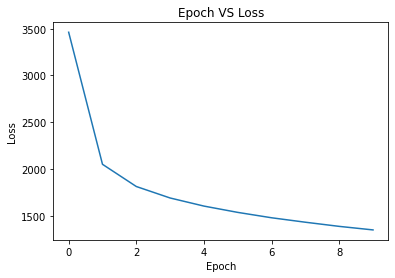

In [ ]:
epoch = range(0, epochSize)
plt.plot(epoch,loss_epoch)
plt.title('Epoch VS Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

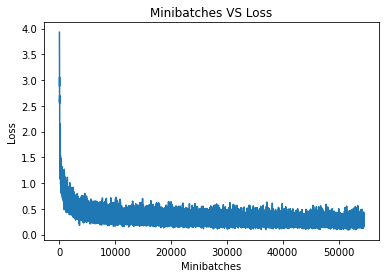

In [ ]:
minibatch = range(0, epochSize*count_batch)
plt.plot(minibatch,loss_minibatch)
plt.title('Minibatches VS Loss')
plt.xlabel('Minibatches')
plt.ylabel('Loss')

Try on Train and Test Datasets

## **T1Q4** 

---

 What is the training and test accuracy? 

In [ ]:
model.eval() # sets the model in evaluation mode 

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = model(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Test dataset
test_correct = 0
test_wrong = 0
test_total = 0
for input_batch, target_batch in test_loader:
  predict_batch = model(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    test_total+=1
    if each.index(max(each)) == result:
      test_correct += 1
    else:
      test_wrong += 1

print('Testing:')
print('number of test data: ' + str(test_total))
print(f'number of wrongly predicted label {test_wrong}')
print(f'test accuracy {(test_correct/test_total)*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training:
number of train data: 697932
number of wrongly predicted label 62130
train accuracy 91.10%
--------------------------------------------------
Testing:
number of test data: 116323
number of wrongly predicted label 13456
test accuracy 88.43%


# **Task 2**

Unsure predictions

In [ ]:
# complete label list
label_list = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt')

# dataloader(size = 1), to get accuracy for each data
train_loader_task2 = DataLoader(dataset=train, batch_size=1,shuffle=False)
test_loader_task2 = DataLoader(dataset=test, batch_size=1, shuffle=False) 

train_dict_num = collections.defaultdict(lambda: collections.defaultdict(int))
train_dict_list = collections.defaultdict(lambda: collections.defaultdict(list))
unsure_dict = collections.defaultdict(dict)

In [ ]:
model.eval() # sets the model in evaluation mode 
threshold = 0.6 # set the threshold to 0.6, it is unsure if the probability is lower than 0.6
# vector_float = np.vectorize(np.float)
# vector_int = np.vectorize(np.int)

for input, target in train_loader_task2:
  output = model(input)
  results = torch.max(output, dim=1)
  
  pred_prob, pred_target = [result.detach().numpy() for result in results]
  pred_prob = float(pred_prob)
  pred_target = int(pred_target)

  target_num = target.numpy()[0]
  
  # track training samples
  train_dict_num[target_num]['training_sample'] += 1

  # unsure
  if pred_prob < threshold: 
    # track total unsure
    train_dict_num[target_num]['unsure_times'] += 1
    # track unsure label
    train_dict_num[target_num][pred_target] += 1
    # track unsure prob
    train_dict_list[target_num][pred_target].append(pred_prob)
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# print(train_dict_num)
# print(train_dict_list)

sorted_train_dict_num = sorted(train_dict_num.items())

for true_label, val in sorted_train_dict_num:
  for key, key_val in val.items():
    if key == 'training_sample':
      train_size = key_val
      unsure_dict[true_label]['total_training_samples'] = train_size
    elif key == 'unsure_times': 
      unsure_size = key_val
      unsure_dict[true_label]['total_unsure_times'] = unsure_size

  # print(f'True label: {label_list[true_label]} \tTotal size: {train_size} \tUnsure Size: {unsure_size}')

In [ ]:
sorted_train_dict_list = sorted(train_dict_list.items())

for true_label, val in sorted_train_dict_list:
  top_unsure_label = None
  top_unsure_label_count = 0
  top_unsure_label_prob_mean = 0

  for key, key_val in val.items():
    # only triggered when unsure
    if key != true_label: 
      if len(key_val) > top_unsure_label_count:
        top_unsure_label = key
        top_unsure_label_count = len(key_val)
        top_unsure_label_prob_mean = np.array(key_val).mean()

  print(f'True label: {label_list[true_label]} \t Top unsure label: {label_list[top_unsure_label]} \t ({top_unsure_label_count}, {top_unsure_label_prob_mean:.2f})')

  unsure_dict[true_label]['top_unsure_pred_label'] = top_unsure_label
  unsure_dict[true_label]['top_num_unsure_pred_label'] = top_unsure_label_count
  unsure_dict[true_label]['top_prob_unsure_pred_label_mean'] = round(top_unsure_label_prob_mean,2)

True label: 0 	 Top unsure label: O 	 (3426, 0.54)
True label: 1 	 Top unsure label: L 	 (2944, 0.50)
True label: 2 	 Top unsure label: Z 	 (27, 0.53)
True label: 3 	 Top unsure label: 2 	 (25, 0.49)
True label: 4 	 Top unsure label: Y 	 (23, 0.52)
True label: 5 	 Top unsure label: S 	 (326, 0.54)
True label: 6 	 Top unsure label: b 	 (87, 0.53)
True label: 7 	 Top unsure label: Y 	 (11, 0.43)
True label: 8 	 Top unsure label: 9 	 (16, 0.44)
True label: 9 	 Top unsure label: g 	 (78, 0.48)
True label: A 	 Top unsure label: a 	 (26, 0.49)
True label: B 	 Top unsure label: 8 	 (32, 0.52)
True label: C 	 Top unsure label: e 	 (120, 0.52)
True label: D 	 Top unsure label: 0 	 (181, 0.49)
True label: E 	 Top unsure label: e 	 (9, 0.51)
True label: F 	 Top unsure label: f 	 (502, 0.53)
True label: G 	 Top unsure label: 6 	 (39, 0.52)
True label: H 	 Top unsure label: 4 	 (15, 0.51)
True label: I 	 Top unsure label: 1 	 (2307, 0.50)
True label: J 	 Top unsure label: I 	 (55, 0.49)
True label:

In [ ]:
dataList = []
for key, val in unsure_dict.items():
  
  total_training_samples = val['total_training_samples']
  total_unsure_times = val['total_unsure_times']
  top_unsure_pred_label = val['top_unsure_pred_label']
  top_num_unsure_pred_label = val['top_num_unsure_pred_label']
  top_prob_unsure_pred_label_mean = val['top_prob_unsure_pred_label_mean']

  dataList.append([label_list[key], total_training_samples, total_unsure_times, 
                   round((total_unsure_times/total_training_samples)*100, 2), label_list[top_unsure_pred_label], 
                   top_num_unsure_pred_label, top_prob_unsure_pred_label_mean])
  
df_task2 = pd.DataFrame(dataList, columns = ['label', '#training samples', '#times unsure', 'percentage %', 'top unsure label, x', '#times unsure with x', 'Averaged P(x)'])

## **T2Q1** 

---

If we take our trained model and use the training data for prediction, for each label, how many times is the prediction unsure? Which label has the highest 'level of unsure'?

> **The dataframe below will show the detail for the unsure prediction for each classes/labels. For example, Label "0" is often confused with label "O"**

> **Label "L" has the highest 'level of unsure' of 40.2% where the label is unsure with the label "1"**



In [ ]:
df_task2

,label,#training samples,#times unsure,percentage %,"top unsure label, x",#times unsure with x,Averaged P(x)
0,0,34618,8760,25.30,O,3426,0.54
1,1,38304,13228,34.53,L,2944,0.50
2,2,34307,239,0.70,Z,27,0.53
3,3,35285,358,1.01,2,25,0.49
4,4,33656,192,0.57,Y,23,0.52
5,5,31280,900,2.88,S,326,0.54
6,6,34150,493,1.44,b,87,0.53
7,7,36020,132,0.37,Y,11,0.43
8,8,33924,392,1.16,9,16,0.44
9,9,33882,585,1.73,g,78,0.48


In [ ]:
#highest for unsure
df_task2[df_task2['percentage %'] == df_task2['percentage %'].max()]

,label,#training samples,#times unsure,percentage %,"top unsure label, x",#times unsure with x,Averaged P(x)
21,L,20381,8194,40.2,1,4042,0.52


## **T2Q2** 

---
What are the reasons that you think the model is unsure in predicting certain labels? What can we say about how our model will perform on the test dataset?


> **In my opinion, we can say that our model will make mistakes sometime when predicting the handwriting images because there might be grey area when seperating those images to different labels/classes. The reasons that cause the model to be unsure in predicting certain labels are:**



1.   **Bad training data due to distortion and bad handwriting (The image is upside down, not clear/blur)**
2.   **Training data is very ambiguous (For example, Z and 2, 0 and O)**





# Task 3

Prediction error : overall and by each labels.

In [ ]:
# dataloader(size = 1)
train_loader_task3 = DataLoader(dataset=train, batch_size=1,shuffle=False)
test_loader_task3 = DataLoader(dataset=test, batch_size=1, shuffle=False) 

wrong_train_dict = collections.defaultdict(lambda: collections.defaultdict(int))
wrong_test_dict = collections.defaultdict(lambda: collections.defaultdict(int))

Train dataset

In [ ]:
model.eval() # sets the model in evaluation mode 

for input, target in train_loader_task3:
  output = model(input)
  results = torch.max(output, dim=1)
  
  pred_prob, pred_target = [result.detach().numpy() for result in results]
  pred_prob = float(pred_prob)
  pred_target = int(pred_target)

  target_num = target.numpy()[0]

  wrong_train_dict[target_num]['total_training_sample'] += 1

  # predict wrong
  if int(target_num) != pred_target: 
    wrong_train_dict[target_num]['wrongly_predicted'] +=1
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test dataset

In [ ]:
model.eval() # sets the model in evaluation mode 

for input, target in test_loader_task3:
  output = model(input)
  results = torch.max(output, dim=1)
  
  pred_prob, pred_target = [result.detach().numpy() for result in results]
  pred_prob = float(pred_prob)
  pred_target = int(pred_target)

  target_num = target.numpy()[0]

  wrong_test_dict[target_num]['total_training_sample'] += 1

  # predict wrong
  if int(target_num) != pred_target: 
    wrong_test_dict[target_num]['wrongly_predicted'] +=1
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Process wrong_train and wrong_test

In [ ]:
# print(wrong_train_dict)
no_training = 697932
sorted_wrong_train_dict = sorted(wrong_train_dict.items())

dataList = []
for true_label, val in sorted_wrong_train_dict:
  for key, key_val in val.items():
    if key == 'total_training_sample':
      train_size = key_val
    elif key == 'wrongly_predicted': 
      wrong_size = key_val

  dataList.append([label_list[true_label], train_size, wrong_size, round((wrong_size/train_size)*100, 2),
                   round((wrong_size/no_training)*100, 2)])
  
df_train_wrong = pd.DataFrame(dataList, columns = ['label', '#training samples', '#wrongly predicted', 'prediction error by labels(%)', 'prediction error overall(%)'])

In [ ]:
# print(wrong_test_dict)
no_testing = 116323
sorted_wrong_test_dict = sorted(wrong_test_dict.items())

dataList = []
for true_label, val in sorted_wrong_test_dict:
  for key, key_val in val.items():
    if key == 'total_training_sample':
      test_size = key_val
    elif key == 'wrongly_predicted': 
      wrong_size = key_val

  dataList.append([label_list[true_label], test_size, wrong_size, round((wrong_size/test_size)*100, 2),
                   round((wrong_size/no_testing)*100, 2)])
  
df_test_wrong = pd.DataFrame(dataList, columns = ['label', '#testing samples', '#wrongly predicted', 'prediction error by labels(%)', 'prediction error overall(%)'])

## **Prediction error on training dataset**

In [ ]:
df_train_wrong

,label,#training samples,#wrongly predicted,prediction error by labels(%),prediction error overall(%)
0,0,34618,9330,26.95,1.34
1,1,38304,5633,14.71,0.81
2,2,34307,222,0.65,0.03
3,3,35285,354,1.00,0.05
4,4,33656,202,0.60,0.03
5,5,31280,1526,4.88,0.22
6,6,34150,574,1.68,0.08
7,7,36020,111,0.31,0.02
8,8,33924,259,0.76,0.04
9,9,33882,445,1.31,0.06


## **Prediction error on testing dataset**

In [ ]:
df_test_wrong

,label,#testing samples,#wrongly predicted,prediction error by labels(%),prediction error overall(%)
0,0,5745,1628,28.34,1.40
1,1,6400,1038,16.22,0.89
2,2,5765,114,1.98,0.10
3,3,5827,118,2.03,0.10
4,4,5498,102,1.86,0.09
5,5,5326,441,8.28,0.38
6,6,5787,191,3.30,0.16
7,7,5873,65,1.11,0.06
8,8,5655,160,2.83,0.14
9,9,5651,123,2.18,0.11


In [ ]:
#highest for prediction error
df_train_wrong[df_train_wrong['prediction error by labels(%)'] == df_train_wrong['prediction error by labels(%)'].max()]

,label,#training samples,#wrongly predicted,prediction error by labels(%),prediction error overall(%)
44,q,2966,1674,56.44,0.24


## **T3Q1** 

---

Which labels has the highest prediction error by labels? Does this agree with the unsure prediction results? For example if label 'z' has the highest 'level of unsure' , is it also reflected here i.e is the prediction error by label for 'z' also is the highest here?

> **From the dataframe shown above, label "q" has the highest prediction error by labels. This does not agree with the unsure prediction results. This is because for some label, it passes the unsure threshold(0.6) but still predicted the wrong output.**

# **Task 4**

Varying models

In [ ]:
# MLP_1: 1 hidden layer
class MLP_1(nn.Module):
  def __init__(self,input_size, hidden_size, num_classes):
    super(MLP_1,self).__init__()
    self.layer1 = nn.Linear(input_size,hidden_size)
    self.layer2 = nn.Linear(hidden_size,num_classes)

  def forward(self,x):
    out = self.layer1(x)
    out = F.sigmoid(out)
    out = self.layer2(out)
    if not self.training:
      out = F.softmax(out,dim=1) # softmax function convert raw value to probabilities (add up to become 1)
    return out

# MLP_2: 2 hidden layer normal
class MLP_2(nn.Module):
  def __init__(self,input_size, hidden_size1, hidden_size2, num_classes):
    super(MLP_2,self).__init__()
    self.layer1 = nn.Linear(input_size,hidden_size1)
    self.layer2 = nn.Linear(hidden_size1,hidden_size2)
    self.layer3 = nn.Linear(hidden_size2,num_classes)

  def forward(self,x):
    out = self.layer1(x)
    out = F.sigmoid(out)
    out = self.layer2(out)
    out = F.sigmoid(out)
    out = self.layer3(out)
    if not self.training:
      out = F.softmax(out,dim=1) # softmax function convert raw value to probabilities (add up to become 1)
    return out

# MLP_2_DROP: 2 hidden layer with dropout
class MLP_2_DROP(nn.Module):
  def __init__(self,input_size, hidden_size1, hidden_size2, num_classes):
    super(MLP_2_DROP,self).__init__()
    self.layer1 = nn.Linear(input_size,hidden_size1)
    self.layer2 = nn.Linear(hidden_size1,hidden_size2)
    self.layerDrop = nn.Dropout(0.2)
    self.layer3 = nn.Linear(hidden_size2,num_classes)

  def forward(self,x):
    out = self.layer1(x)
    out = F.sigmoid(out)
    out = self.layer2(out)
    out = F.sigmoid(out)
    out = self.layerDrop(out)
    out = self.layer3(out)
    if not self.training:
      out = F.softmax(out,dim=1) # softmax function convert raw value to probabilities (add up to become 1)
    return out

# MLP_3: 3 hidden layer
class MLP_3(nn.Module):
  def __init__(self,input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
    super(MLP_3,self).__init__()
    self.layer1 = nn.Linear(input_size,hidden_size1)
    self.layer2 = nn.Linear(hidden_size1,hidden_size2)
    self.layer3 = nn.Linear(hidden_size2,hidden_size3)
    self.layer4 = nn.Linear(hidden_size3,num_classes)

  def forward(self,x):
    out = self.layer1(x)
    out = F.sigmoid(out)
    out = self.layer2(out)
    out = F.sigmoid(out)
    out = self.layer3(out)
    out = F.sigmoid(out)
    out = self.layer4(out)
    if not self.training:
      out = F.softmax(out,dim=1) # softmax function convert raw value to probabilities (add up to become 1)
    return out

In [ ]:
input_size = 784
num_classes = 47

'''
According to "https://www.heatonresearch.com/2017/06/01/hidden-layers.html", 
the best number of hidden layer is 2/3 * input + output
'''

model_layer1 = MLP_1(input_size, 570, num_classes)
model_layer2 = MLP_2(input_size, 570, 427, num_classes)
model_layer2drop = MLP_2_DROP(input_size, 570, 427, num_classes)
model_layer3 = MLP_3(input_size, 570, 427, 332, num_classes)

In [ ]:
# if wan to use old model,
# build the model and load state from drive

model_layer1.load_state_dict(torch.load('model1.weights'))
model_layer2.load_state_dict(torch.load('model2.weights'))
model_layer2drop.load_state_dict(torch.load('model2drop.weights'))
model_layer3.load_state_dict(torch.load('model3.weights'))

<All keys matched successfully>

In [ ]:
num_epochs = 10

loss_fn = nn.CrossEntropyLoss() #calculate loss by surprise compare to the result
opt1 = torch.optim.Adam(model_layer1.parameters()) #optimizer, optimization strategy to escape the local minima and to converge quickly
opt2n = torch.optim.Adam(model_layer2.parameters())
opt2d = torch.optim.Adam(model_layer2drop.parameters())
opt3 = torch.optim.Adam(model_layer3.parameters())

loss_epoch1 = []
loss_epoch2n = []
loss_epoch2d = []
loss_epoch3 = []

print("Training 1 Layer:")
for epoch in range(num_epochs):
  model_layer1.train()
  loss = 0

  for input, target_batch in train_loader:
    opt1.zero_grad() #zero the gradients
    predict_batch = model_layer1(input) #forward
    loss_batch = loss_fn(predict_batch, target_batch) #loss
    loss_batch.backward() #backward

    opt1.step() #optimize i.e update weights
    loss += loss_batch.item()

  loss_epoch1.append(loss)
  print(f'Epoch: {epoch+1}  loss: {loss}')
print(f'Learning parameters is: {sum(p.numel() for p in model_layer1.parameters() if p.requires_grad)}')

print("---------------------------------------\n")
print("Training 2 Layer Normal:")
for epoch in range(num_epochs):
  model_layer2.train()
  loss = 0

  for input, target_batch in train_loader:
    opt2n.zero_grad() #zero the gradients
    predict_batch = model_layer2(input) #forward
    loss_batch = loss_fn(predict_batch, target_batch) #loss
    loss_batch.backward() #backward

    opt2n.step() #optimize i.e update weights
    loss += loss_batch.item()

  loss_epoch2n.append(loss)
  print(f'Epoch: {epoch+1}  loss: {loss}')
print(f'Learning parameters is: {sum(p.numel() for p in model_layer2.parameters() if p.requires_grad)}')

print("---------------------------------------\n")
print("Training 2 Layer With Dropout:")
for epoch in range(num_epochs):
  model_layer2drop.train()
  loss = 0

  for input, target_batch in train_loader:
    opt2d.zero_grad() #zero the gradients
    predict_batch = model_layer2drop(input) #forward
    loss_batch = loss_fn(predict_batch, target_batch) #loss
    loss_batch.backward() #backward

    opt2d.step() #optimize i.e update weights
    loss += loss_batch.item()

  loss_epoch2d.append(loss)
  print(f'Epoch: {epoch+1}  loss: {loss}')
print(f'Learning parameters is: {sum(p.numel() for p in model_layer2drop.parameters() if p.requires_grad)}')

print("---------------------------------------\n")
print("Training 3 Layer:")
for epoch in range(num_epochs):
  model_layer3.train()
  loss = 0

  for input, target_batch in train_loader:
    opt3.zero_grad() #zero the gradients
    predict_batch = model_layer3(input) #forward
    loss_batch = loss_fn(predict_batch, target_batch) #loss
    loss_batch.backward() #backward

    opt3.step() #optimize i.e update weights
    loss += loss_batch.item()

  loss_epoch3.append(loss)
  print(f'Epoch: {epoch+1}  loss: {loss}')
print(f'Learning parameters is: {sum(p.numel() for p in model_layer3.parameters() if p.requires_grad)}')
  

Training 1 Layer:


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1  loss: 3592.762931868434
Epoch: 2  loss: 2123.9297639876604
Epoch: 3  loss: 1876.63915091753
Epoch: 4  loss: 1749.9222966581583
Epoch: 5  loss: 1664.163652047515
Epoch: 6  loss: 1599.2883858680725
Epoch: 7  loss: 1546.9042731747031
Epoch: 8  loss: 1503.2840023860335
Epoch: 9  loss: 1466.1997097432613
Epoch: 10  loss: 1431.4080578237772
Learning parameters is: 474287
---------------------------------------

Training 2 Layer Normal:
Epoch: 1  loss: 3373.6358383893967
Epoch: 2  loss: 1965.7264832258224
Epoch: 3  loss: 1748.2424503713846
Epoch: 4  loss: 1625.894359447062
Epoch: 5  loss: 1535.5958795323968
Epoch: 6  loss: 1466.634048372507
Epoch: 7  loss: 1405.053208976984
Epoch: 8  loss: 1351.844237446785
Epoch: 9  loss: 1307.224023066461
Epoch: 10  loss: 1261.9590732827783
Learning parameters is: 711383
---------------------------------------

Training 2 Layer With Dropout:
Epoch: 1  loss: 3514.463055074215
Epoch: 2  loss: 2043.434069827199
Epoch: 3  loss: 1819.6404517591
Epoch: 

In [ ]:
# save loss to drive

losses = [loss_epoch1,loss_epoch2n,loss_epoch2d,loss_epoch3]

with open('./losses.txt', 'a') as testwritefile:
    testwritefile.write(str(losses))

In [ ]:
# read loss from drive

loss_epoch1,loss_epoch2n,loss_epoch2d,loss_epoch3 = [],[],[],[]
losses = [loss_epoch1,loss_epoch2n,loss_epoch2d,loss_epoch3]

with open('./losses.txt', 'r') as testwritefile:
    lossess = testwritefile.read()

for losses_each, losses_list in zip(lossess.split("[[")[1].split("]]")[0].split("], ["),losses):
  for each in losses_each.split(","):
    losses_list.append(float(each.strip()))

## **Training Loss**

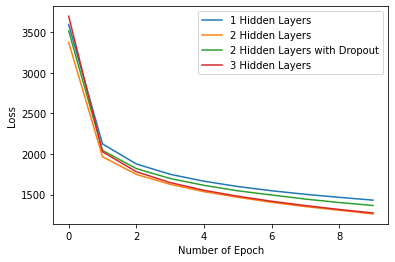

In [ ]:
num_epochs = 10

plt.plot(range(num_epochs), loss_epoch1, label="1 Hidden Layers")
plt.plot(range(num_epochs), loss_epoch2n, label="2 Hidden Layers")
plt.plot(range(num_epochs), loss_epoch2d, label="2 Hidden Layers with Dropout")
plt.plot(range(num_epochs), loss_epoch3, label="3 Hidden Layers")
plt.title('Training loss')
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
plt.legend()

## **Compare and Explain**

---



Compare different models and observe how different architecture affects the convergence. You need to explain why do you think your results are as such. 
> **From the graph, we can see that the more the Layer, the lower loss it will achieve. This is because of there are more learning parameters when there are more neurons, so they will converge faster. Therefore, in this case, model with 3 Layers achieved the best result.**

Can we say deeper networks are better than shallow ones?
> **From the graph, we observe that 3 Layers achieve lower train loss compared to 1 Layer ,2 Layers and 2 Layers with Dropout. So, it is a YES.**

Compare the effect of implementing dropout.
> **From the graph, we can see that the one without dropout perform better than the one with dropout. However from the Accuracy and Prediction graph below, we can see that for "with dropout", the accuracy of training set will be lower but for testing data, it is higher compared to "normal". Here comes the theory part, dropout is to prevent overfitting of model by improving the model generalization. So, there will be some trade off between trainng accuracy and testing accuracy when using dropout**


In [ ]:
# save weights after trained
torch.save(model_layer1.state_dict(), "./model1.weights")
torch.save(model_layer2.state_dict(), "./model2.weights")
torch.save(model_layer2drop.state_dict(), "./model2drop.weights")
torch.save(model_layer3.state_dict(), "./model3.weights")

In [ ]:
# Evaluation mode
model_layer1 = model_layer1.eval()
model_layer2 = model_layer2.eval()
model_layer2drop = model_layer2drop.eval()
model_layer3 = model_layer3.eval()

In [ ]:
def eval_model_acc_err(loader,model):
  n_correct = 0
  n_total = 0

  for input_batch, target_batch in loader:
    predict_batch = model(input_batch) 
    _, predictions = torch.max(predict_batch, 1)
    n_total += target_batch.shape[0]
    n_correct += (predictions == target_batch).sum().item()

  acc = round((n_correct / n_total)*100,2)
  err = round(1-(n_correct / n_total),2)
  # print(f'number of data: {n_total}')
  # print(f'number of wrongly predicted label: {n_total - n_correct}')
  # print(f'Accuracy: {acc}')
  return acc,err

In [ ]:
print("Training Data:")
print('1 Layer...')
train1_acc,train1_err = eval_model_acc_err(train_loader, model_layer1)

print('2 Layer Normal...')
train2n_acc,train2n_err = eval_model_acc_err(train_loader, model_layer2)

print('2 Layer Dropout...')
train2d_acc,train2d_err = eval_model_acc_err(train_loader, model_layer2drop)

print('3 Layer...')
train3_acc,train3_err = eval_model_acc_err(train_loader, model_layer3)

print("\nTesting Data:")
print('1 Layer...')
test1_acc,test1_err = eval_model_acc_err(test_loader, model_layer1)

print('2 Layer Normal...')
test2n_acc,test2n_err = eval_model_acc_err(test_loader, model_layer2)

print('2 Layer Dropout...')
test2d_acc,test2d_err = eval_model_acc_err(test_loader, model_layer2drop)

print('3 Layer...')
test3_acc,test3_err = eval_model_acc_err(test_loader, model_layer3)

Training Data:
1 Layer...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2 Layer Normal...
2 Layer Dropout...
3 Layer...

Testing Data:
1 Layer...
2 Layer Normal...
2 Layer Dropout...
3 Layer...


In [ ]:
params_m1 = sum(p.numel() for p in model_layer1.parameters() if p.requires_grad)
params_m2 = sum(p.numel() for p in model_layer2.parameters() if p.requires_grad)
params_m2drop = sum(p.numel() for p in model_layer2drop.parameters() if p.requires_grad)
params_m3 = sum(p.numel() for p in model_layer3.parameters() if p.requires_grad)
params_all = [params_m1,params_m2,params_m2drop,params_m3]

train_acc_all = [train1_acc,train2n_acc,train2d_acc,train3_acc]
test_acc_all = [test1_acc,test2n_acc,test2d_acc,test3_acc]

train_err_all = [train1_err,train2n_err,train2d_err,train3_err]
test_err_all = [test1_err,test2n_err,test2d_err,test3_err]

## **Accuracy and Perdiction Error**

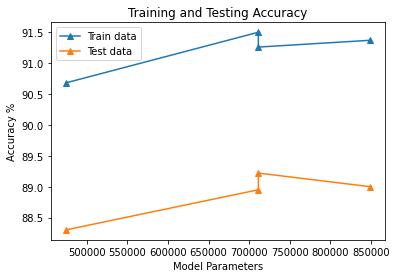

In [ ]:
plt.plot(params_all,train_acc_all,marker='^',label='Train data')
plt.plot(params_all,test_acc_all,marker='^',label='Test data')
plt.title('Training and Testing Accuracy')
plt.xlabel("Model Parameters")
plt.ylabel("Accuracy %")
plt.legend()

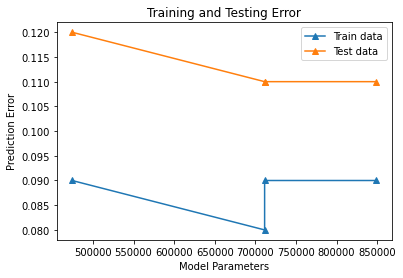

In [ ]:
plt.plot(params_all,train_err_all,marker='^',label='Train data')
plt.plot(params_all,test_err_all,marker='^',label='Test data')
plt.title('Training and Testing Error')
plt.xlabel("Model Parameters")
plt.ylabel("Prediction Error")
plt.legend()

## **Complex Model: Overfit**

In [ ]:
# MLP_Over: 5 hidden layer
class MLP_Over(nn.Module):
  def __init__(self,input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, num_classes):
    super(MLP_Over,self).__init__()
    self.layer1 = nn.Linear(input_size,hidden_size1)
    self.layer2 = nn.Linear(hidden_size1,hidden_size2)
    self.layer3 = nn.Linear(hidden_size2,hidden_size3)
    self.layer4 = nn.Linear(hidden_size3,hidden_size4)
    self.layer5 = nn.Linear(hidden_size4,hidden_size5)
    self.layer6 = nn.Linear(hidden_size5,num_classes)

  def forward(self,x):
    out = self.layer1(x)
    out = F.sigmoid(out)
    out = self.layer2(out)
    out = F.sigmoid(out)
    out = self.layer3(out)
    out = F.sigmoid(out)
    out = self.layer4(out)
    out = F.sigmoid(out)
    out = self.layer5(out)
    out = F.sigmoid(out)
    out = self.layer6(out)
    if not self.training:
      out = F.softmax(out,dim=1) # softmax function convert raw value to probabilities (add up to become 1)
    return out

In [ ]:
model_over = MLP_Over(784, 784, 570, 427, 332, 268, 47)
loss_fn = nn.CrossEntropyLoss() #calculate loss by surprise compare to the result
optOver = torch.optim.Adam(model_over.parameters()) #optimizer, optimization strategy to escape the local minima and to converge quickly
loss_epochOver = []
num_epochs = 40

print("Training Overfit:")
for epoch in range(num_epochs):
  model_over.train()
  loss = 0

  for input, target_batch in train_loader:
    optOver.zero_grad() #zero the gradients
    predict_batch = model_over(input) #forward
    loss_batch = loss_fn(predict_batch, target_batch) #loss
    loss_batch.backward() #backward

    optOver.step() #optimize i.e update weights
    loss += loss_batch.item()

  loss_epochOver.append(loss)
  print(f'Epoch: {epoch+1}  loss: {loss}')
print(f'Learning parameters is: {sum(p.numel() for p in model_over.parameters() if p.requires_grad)}')

Training Overfit:


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1  loss: 4947.825790554285
Epoch: 2  loss: 2166.6595261991024
Epoch: 3  loss: 1862.7182826250792
Epoch: 4  loss: 1698.5112324357033
Epoch: 5  loss: 1591.233895123005
Epoch: 6  loss: 1504.1186758875847
Epoch: 7  loss: 1436.8928332701325
Epoch: 8  loss: 1380.2372632548213
Epoch: 9  loss: 1332.4601066485047
Epoch: 10  loss: 1285.7509410008788
Epoch: 11  loss: 1248.0802166685462
Epoch: 12  loss: 1209.6607576161623
Epoch: 13  loss: 1178.403088800609
Epoch: 14  loss: 1150.3522407859564
Epoch: 15  loss: 1125.3539314046502
Epoch: 16  loss: 1099.3443996459246
Epoch: 17  loss: 1075.18988738209
Epoch: 18  loss: 1053.591746006161
Epoch: 19  loss: 1033.9064035788178
Epoch: 20  loss: 1016.5588414929807
Epoch: 21  loss: 997.1094965040684
Epoch: 22  loss: 977.9048283323646
Epoch: 23  loss: 963.7146993763745
Epoch: 24  loss: 945.0569923073053
Epoch: 25  loss: 930.6513876095414
Epoch: 26  loss: 915.2481474652886
Epoch: 27  loss: 899.2115360461175
Epoch: 28  loss: 886.6667046099901
Epoch: 29  loss

In [ ]:
torch.save(model_over.state_dict(), "./modelover.weights")

In [ ]:
model_over = MLP_Over(784, 784, 570, 427, 332, 268, 47)
model_over.load_state_dict(torch.load('modelover.weights'))

<All keys matched successfully>

In [ ]:
trainOver_acc,trainOver_err = eval_model_acc_err(train_loader, model_over)
testOver_acc,testOver_err = eval_model_acc_err(test_loader, model_over)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## **Observe Overfitting**

In [ ]:
params_over = sum(p.numel() for p in model_over.parameters() if p.requires_grad)
params_all = [params_m1,params_m2,params_m2drop,params_m3,params_over]

train_acc_all = [train1_acc,train2n_acc,train2d_acc,train3_acc,trainOver_acc]
test_acc_all = [test1_acc,test2n_acc,test2d_acc,test3_acc,testOver_acc]

train_err_all = [train1_err,train2n_err,train2d_err,train3_err,trainOver_err]
test_err_all = [test1_err,test2n_err,test2d_err,test3_err,testOver_err]

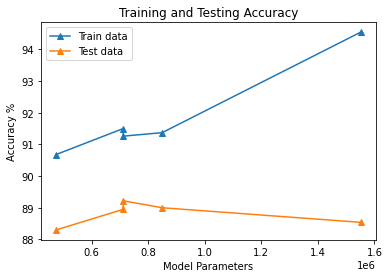

In [ ]:
plt.plot(params_all,train_acc_all,marker='^',label='Train data')
plt.plot(params_all,test_acc_all,marker='^',label='Test data')
plt.title('Training and Testing Accuracy')
plt.xlabel("Model Parameters")
plt.ylabel("Accuracy %")
plt.legend()

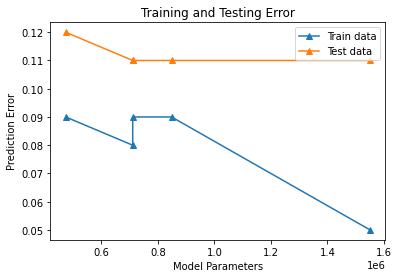

In [ ]:
plt.plot(params_all,train_err_all,marker='^',label='Train data')
plt.plot(params_all,test_err_all,marker='^',label='Test data')
plt.title('Training and Testing Error')
plt.xlabel("Model Parameters")
plt.ylabel("Prediction Error")
plt.legend()

Explaination:


> **From the Accuray and Predction error graph, we can clearly see that the result of the last model is overfit. It is because of the training accuracy can reach around 95% while it only achieve around 88.5% for testing data. Therefore, we can conclude that the last model is overfitting the training datasets.**




